In [1]:
import os
import numpy as np
import pandas as pd
import SimpleITK as sitk
import matplotlib.pyplot as plt

In [2]:
def window_transform(ct_array, windowWidth, windowCenter, normal=False):
    """
    return: trucated image according to window center and window width
    and normalized to [0,1]
    """
    minWindow = float(windowCenter) - 0.5*float(windowWidth)
    # print(minWindow)
    newimg = (ct_array - minWindow) / float(windowWidth)
    newimg[newimg < 0] = 0
    newimg[newimg > 1] = 1
    if not normal:
        newimg = (newimg * 255).astype('uint8')
    return newimg

In [1]:
def mask_to_onehot(mask, palette):
    """
    Converts a segmentation mask (H, W, C) to (H, W, K) where the last dim is a one
    hot encoding vector, C is usually 1 or 3, and K is the number of class.
    """
    semantic_map = []
    for colour in palette:
        equality = np.equal(mask, colour)
        class_map = np.all(equality, axis=-1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1).astype(np.float32)
    return semantic_map

def onehot_to_mask(mask, palette):
    """
    Converts a mask (H, W, K) to (H, W, C)
    """
    x = np.argmax(mask, axis=-1)
    colour_codes = np.array(palette)
    x = np.uint8(colour_codes[x.astype(np.uint8)])
    return x

In [3]:
# 肺窗调整到[-1250, 250]

data_path = "/zhangtong/org_dataset/COVID-19-CT-Seg_20cases/"
ct_path = os.path.join(data_path, "ct_scans")
lung_path = os.path.join(data_path, "Lung_Mask")
infection_path = os.path.join(data_path, "infection_mask")

In [4]:
data_dict = {}
image_save_path = "/zhangtong/dealed_dataset/covid_seg_20_cases_m/ct_scans/"
lung_seg_image_save_path = "/zhangtong/dealed_dataset/covid_seg_20_cases_m/ct_scans_lung/"
infection_mask_save_path = "/zhangtong/dealed_dataset/covid_seg_20_cases_m/infection_mask/"

for file in os.listdir(ct_path):
    if file == "ReadMe.txt":
        continue
    filename = file.split(".")
    ct = sitk.ReadImage(os.path.join(ct_path, file))
    ct_array = sitk.GetArrayFromImage(ct)
    if not file.startswith("ra"):
        ct_array = window_transform(ct_array * 1.0, 1500, -500)
    
    lung_mask = sitk.ReadImage(os.path.join(lung_path, file))
    lung_mask_arr = sitk.GetArrayFromImage(lung_mask)
    
    infection_mask = sitk.ReadImage(os.path.join(infection_path, file))
    infection_mask_arr = sitk.GetArrayFromImage(infection_mask)
    
    lung_mask_arr[lung_mask_arr == 2] = 1
    
    data_list = []
    print("start process {}".format(file))
    for i in range(ct_array.shape[0]):
        if np.max(infection_mask_arr[i]) > 0:
            image_path = os.path.join(image_save_path, "{}_{}.npy".format(filename[0], i))
            lung_seg_image_path = os.path.join(lung_seg_image_save_path, "{}_{}.npy".format(filename[0], i))
            infection_mask_path = os.path.join(infection_mask_save_path, "{}_{}.npy".format(filename[0], i))
            
            np.save(image_path, ct_array[i])
            np.save(lung_seg_image_path, ct_array[i] * lung_mask_arr[i])
            np.save(infection_mask_path, infection_mask_arr[i])
            
            data_list.append({
                "image_path": image_path,
                "lung_seg_image": lung_seg_image_path,
                "infection_mask": infection_mask_path,
            })
        else:
            continue
    data_dict[filename[0]] = data_list

start process radiopaedia_29_86490_1.nii.gz
start process radiopaedia_14_85914_0.nii.gz
start process radiopaedia_10_85902_3.nii.gz
start process coronacases_003.nii.gz
start process coronacases_004.nii.gz
start process coronacases_007.nii.gz
start process radiopaedia_7_85703_0.nii.gz
start process coronacases_006.nii.gz
start process coronacases_008.nii.gz
start process radiopaedia_10_85902_1.nii.gz
start process radiopaedia_40_86625_0.nii.gz
start process radiopaedia_27_86410_0.nii.gz
start process coronacases_005.nii.gz
start process radiopaedia_36_86526_0.nii.gz
start process radiopaedia_4_85506_1.nii.gz
start process coronacases_001.nii.gz
start process radiopaedia_29_86491_1.nii.gz
start process coronacases_002.nii.gz
start process coronacases_009.nii.gz
start process coronacases_010.nii.gz


In [5]:
import json
with open("test.json", 'w', encoding='utf-8') as f:
    f.write(json.dumps(data_dict))

In [26]:
key_list = list(data_dict.keys())

In [ ]:
# 与肺分割数据集分割样本一致，方便后续测试

In [29]:
train = ['coronacases_005', 'radiopaedia_29_86490_1', 'radiopaedia_36_86526_0', 'coronacases_010', 'coronacases_001', 'radiopaedia_40_86625_0', 'coronacases_007', 'radiopaedia_29_86491_1', 'coronacases_002', 'coronacases_008', 'radiopaedia_4_85506_1', 'radiopaedia_27_86410_0', 'radiopaedia_10_85902_1', 'coronacases_004']
test = ['radiopaedia_14_85914_0', 'coronacases_009', 'coronacases_003', 'radiopaedia_10_85902_3']
valid = ['radiopaedia_7_85703_0', 'coronacases_006']

In [30]:
train_data = []
for item in train:
    train_data += data_dict[item]
with open("lung_seg_train.json", "w", encoding="utf-8") as f:
    f.write(json.dumps(train_data))

In [31]:
valid_data = []
for item in valid:
    valid_data += data_dict[item]
with open("lung_seg_valid.json", "w", encoding="utf-8") as f:
    f.write(json.dumps(valid_data))

In [32]:
test_data = []
for item in test:
    test_data += data_dict[item]
with open("lung_seg_test.json", "w", encoding="utf-8") as f:
    f.write(json.dumps(test_data))

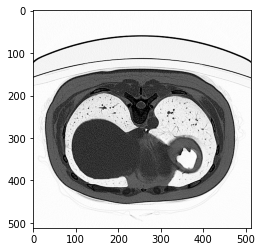

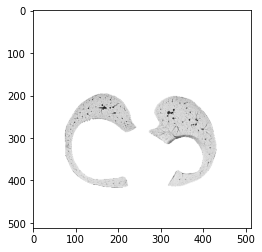

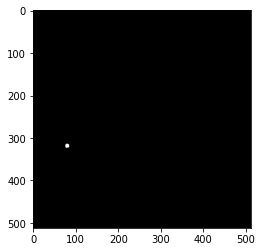

In [25]:
plt.imshow(image, cmap='Greys')
plt.show()
plt.imshow(lung_seg_image, cmap='Greys')
plt.show()
plt.imshow(infection_mask, cmap='gray')
plt.show()